# Examples -- Change in streamflow by elevation

In this example, we will look at HUC4 1803 and 1804 to the west of the San Francisco Bay. This includes the High Sierras to the bay.

![](../metadata/wr18_map.png)

## Load the data.

In [12]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

import xarray as xr
zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr"
ds = xr.open_zarr(zarr_url, consolidated=True)

<xarray.Dataset> Size: 43GB
Dimensions:     (time: 16072, feature_id: 332880)
Coordinates:
    elevation   (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
  * feature_id  (feature_id) int64 3MB 341095 341097 ... 948100739 948100740
    gage_id     (feature_id) |S15 5MB dask.array<chunksize=(5000,), meta=np.ndarray>
    latitude    (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
    longitude   (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
    order       (feature_id) int32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
  * time        (time) datetime64[ns] 129kB 1979-02-01 1979-02-02 ... 2023-02-01
Data variables:
    crs         (time) int64 129kB dask.array<chunksize=(365,), meta=np.ndarray>
    streamflow  (time, feature_id) float64 43GB dask.array<chunksize=(365, 5000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                   CF-1.7 CF-1.8
    featureType:                   timeSeries
    g

## Mean flow by decade

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Define elevation bins (in meters)
bins = [0, 500, 1000, 1500, 2000, 2500, 3000]
labels = [f"{bins[i]}–{bins[i+1]} m" for i in range(len(bins)-1)]

# Bin the elevation values
elevation_band = xr.apply_ufunc(
    np.digitize,
    ds.elevation,
    kwargs={"bins": bins},
    dask="allowed",
    output_dtypes=[int],
    vectorize=True  # <- this is key
)

# Now add this band info as a coordinate
ds = ds.assign_coords(elevation_band=("feature_id", elevation_band.data))

# Group by elevation band and compute mean across features
grouped = ds.streamflow.groupby("elevation_band").mean(dim="feature_id")


In [18]:
# Then average over time to get a single mean per band
mean_by_band = grouped.mean(dim="time")

In [20]:
mean_by_band

<xarray.DataArray 'streamflow' (elevation_band: 8)> Size: 64B
dask.array<mean_agg-aggregate, shape=(8,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * elevation_band  (elevation_band) int64 64B 0 1 2 3 4 5 6 7

In [53]:
# Group by elevation band and average across features
# shape: (time, band)
elevation_ts = ds.streamflow.groupby("elevation_band").mean(dim="feature_id")


In [54]:
elevation_ts

<xarray.DataArray 'streamflow' (time: 16072, elevation_band: 8)> Size: 1MB
dask.array<groupby_nanmean, shape=(16072, 8), dtype=float64, chunksize=(365, 8), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 129kB 1979-02-01 ... 2023-02-01
  * elevation_band  (elevation_band) int64 64B 0 1 2 3 4 5 6 7
Attributes:
    description:    Daily mean streamflow calculated from hourly NWM v3.0 str...
    grid_mapping:   crs
    long_name:      streamflow (discharge)
    standard_name:  river_discharge
    units:          m3 s-1

In [55]:
%%time
# Compute the actual values (if Dask-backed)
elevation_ts = elevation_ts.compute()


CPU times: user 3min 17s, sys: 20 s, total: 3min 37s
Wall time: 2min 53s


In [56]:
elevation_ts.to_netcdf("banded_streamflow_by_elevation.nc")

In [58]:
# Get band labels
banded_ts = elevation_ts
band_values = banded_ts.elevation_band.values.astype(int)

# Only keep values in valid range (1 to len(bins) - 1)
valid_band_values = [i for i in band_values if 1 <= i < len(bins)]

# Build labels safely
labels_present = [f"{bins[i-1]}–{bins[i]} m" for i in valid_band_values]

# Assign to banded_ts (make sure ordering matches)
banded_ts = banded_ts.sel(elevation_band=valid_band_values)
banded_ts = banded_ts.assign_coords(
    elevation_band=("elevation_band", labels_present)
)


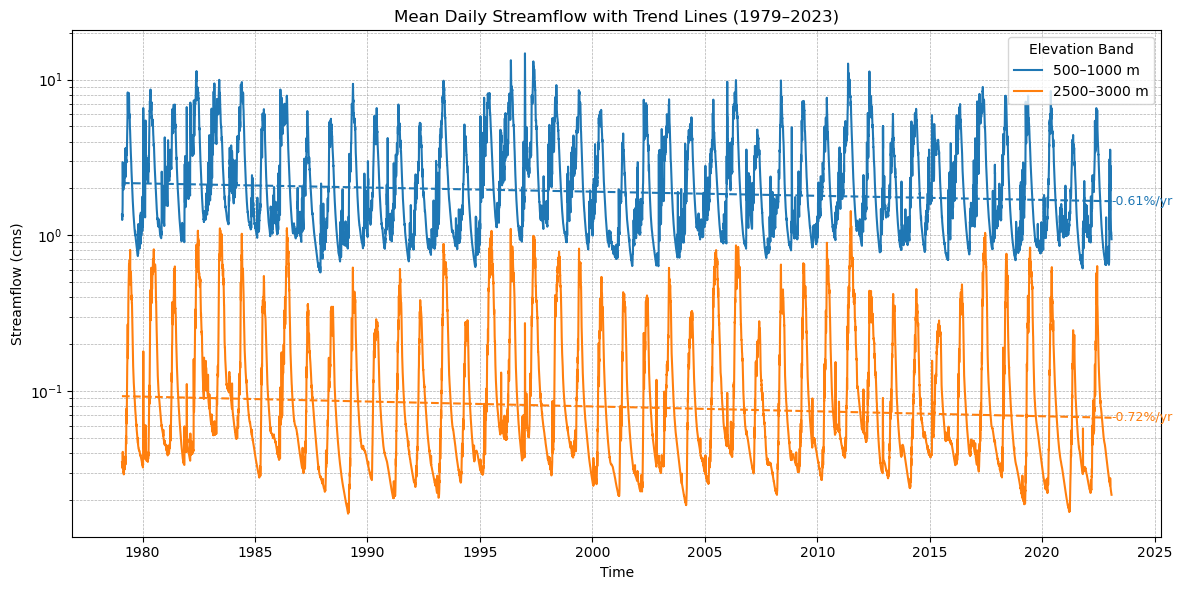

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(12, 6))

for label in banded_ts_sel.elevation_band.values:
    ts = banded_ts_sel.sel(elevation_band=label)

    # Convert time to decimal years
    time = banded_ts_sel.time
    years = (time.dt.year + time.dt.dayofyear / 365).values
    flow = ts.values

    # Mask to avoid log(0) or NaNs
    mask = np.isfinite(flow) & (flow > 0)

    # Plot raw data (with legend)
    ax.plot(time, flow, label=label)

    # Linear regression on log(flow)
    log_flow = np.log(flow[mask])
    slope, intercept, *_ = linregress(years[mask], log_flow)

    # Create and plot trendline (no label → no legend entry)
    trend = np.exp(intercept + slope * years)
    ax.plot(time, trend, linestyle="--", color=ax.lines[-1].get_color())

    # Compute percent change per year
    pct_per_year = (np.exp(slope) - 1) * 100

    # Annotate near the end of the time series
    ax.text(
        time[-1].values,
        trend[-1],
        f"{pct_per_year:+.2f}%/yr",
        fontsize=9,
        verticalalignment="center",
        color=ax.lines[-1].get_color()
    )

ax.set_title("Mean Daily Streamflow with Trend Lines (1979–2023)")
ax.set_xlabel("Time")
ax.set_ylabel("Streamflow (cms)")
ax.set_yscale("log")
ax.legend(title="Elevation Band", loc="upper right")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



In [67]:
summary_lines = []

for label in banded_ts_sel.elevation_band.values:
    ts = banded_ts_sel.sel(elevation_band=label)

    # Convert time to decimal years
    time = banded_ts_sel.time
    years = (time.dt.year + time.dt.dayofyear / 365).values
    flow = ts.values

    # Mask for valid values
    mask = np.isfinite(flow) & (flow > 0)
    log_flow = np.log(flow[mask])
    slope, intercept, *_ = linregress(years[mask], log_flow)
    trend = np.exp(intercept + slope * years)

    # Total change from start to end
    flow_start = trend[0]
    flow_end = trend[-1]
    abs_change = flow_end - flow_start
    pct_change = (flow_end / flow_start - 1) * 100

    summary_lines.append(
        f"{label}: {pct_change:+.2f}% change ({abs_change:+.2f} cms) from 1979 to 2023"
    )

# Print summary
print("\nStreamflow trend summary:")
print("\n".join(summary_lines))


Streamflow trend summary:
500–1000 m: -23.55% change (-0.51 cms) from 1979 to 2023
2500–3000 m: -27.31% change (-0.03 cms) from 1979 to 2023
